### 此專案來套用所提出之EVCC模型於 PEWC 資料###

In [1]:
# import used functioons 
#  import tools 
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose
from tensorflow.keras.layers import Add, Concatenate,LSTM, TimeDistributed, MultiHeadAttention, LayerNormalization


from tensorflow.keras.utils import plot_model

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices found:")
    for gpu in gpus:
        print(gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train

import random
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(42)

def read_rul_data_PEWC(filepath, default_spd=0, default_trq=0, default_pwr=0, default_eff=0):

    data_read = None
    # 檢查檔案是否存在
    if os.path.exists(filepath):
        if filepath.endswith('.parquet'):
            df_loaded = pd.read_parquet(filepath)
            tt=np.array(df_loaded["Voltage alpha"].iloc[0])
            data_read = {
                "Unix Time": df_loaded["Unix Time"].iloc[0],
                "Speed": [df_loaded["Speed"].iloc[0]],
                "Torque": [df_loaded["Torque"].iloc[0]],
                "Power": [df_loaded["Power"].iloc[0]],
                "Efficiency": [df_loaded["Efficiency"].iloc[0]],
                "vibration rms": [df_loaded["vibration rms"].iloc[0]] if "vibration rms" in df_loaded else [],
                "Voltage alpha": np.array([df_loaded["Voltage alpha"].iloc[0]]).T,
                "Voltage beta": np.array([df_loaded["Voltage beta"].iloc[0]]).T,
                "Current alpha": np.array([df_loaded["Current alpha"].iloc[0]]).T,  # 轉為 List
                "Current beta": np.array([df_loaded["Current beta"].iloc[0]]).T,
                "vibration data": np.array([df_loaded["vibration data"].iloc[0]]).T if "vibration rms" in df_loaded else [],
            }
        elif filepath.endswith('.csv'):
            # csv read code version
            # read time stamp from first line
            with open(filepath, "r") as file:
                first_line = file.readline().strip()  # 讀取第一行並去掉換行符
            unix_time = first_line.split(",")[1]  # 取第二個欄位 (1736773960)

            # read rest of the data
            # df_loaded=pd.read_csv(filepath, skiprows=1, names=["V_alpha", "V_beta", "I_alpha", "I_beta"])
            df_loaded = pd.read_csv(filepath, skiprows=1)

            data_read = {
                "Unix Time": unix_time,
                "Speed":    [default_spd],
                "Torque":   [default_trq],
                "Power":    [default_pwr],
                "Efficiency": [default_eff],
                "Voltage alpha": df_loaded["V_alpha"].to_numpy(),
                "Voltage beta": df_loaded["V_beta"].to_numpy(),
                "Current alpha":df_loaded["I_alpha"].to_numpy(),
                "Current beta": df_loaded["I_beta"].to_numpy(),
                "vibration rms": [0],
            }
        else:
            print(f"Unsupported file format: {filepath}")
            return data_read


    else:
        print(f"檔案 {filepath} 不存在，請確認檔案路徑。")
    return data_read



GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Create ccae model

In [2]:
from datetime import datetime
import json


sequence_length=1024
future_length=512
model_folder_path = r'NTU_rul_models\CCAE_models\PEWC'
model_name = f'0822_multiscale_CCAE_Base{sequence_length}'
model_path = os.path.join(model_folder_path, model_name)
os.makedirs(model_path, exist_ok=True)

def build_cnn_multi_branch_ae(
    input_dim_list,
    sequence_length,
    condition_dim,
    model_folder_path=None,
    model_name=None,
    iscondition=True,
    # 第一層（分支前）設定
    first_kernel_size=64,      # 第一層 kernel size
    first_layer_filters=None,  # 若為 None，預設用 base_filters
    first_stride=1,            # 第一層 stride（可自訂）
    # 分支 kernels（每個分支全程沿用自己的 k）
    first_branch_kernels=(3, 5, 7),
    # 既有參數
    base_filters=32,
    blocks=3,
    decay=0.5,
    filters_per_block=None,
    # 反捲積（還原第一層 stride）kernel，預設沿用 first_kernel_size
    deconv_kernel_size=None
):
    """
    - Stem：Conv1D(filters=first_layer_filters, kernel_size=first_kernel_size, strides=first_stride, padding='same')
    - Encoder（多分支）：各分支全程用自己的 k；每層 strides=2
    - Bottleneck：Conv1D(k, stride=1)
    - Decoder（多分支）：UpSampling(2)+Conv1D(k, stride=1)
    - Merge 後：只做 1x1 Conv 融合（已移除 3x1 fusion conv）
    - 還原第一層 stride：以「每通道 Conv1DTranspose」(groups=channels, stride=first_stride)
    - **不再強制裁切輸出長度**
    """
    from tensorflow.keras.layers import (
        Input, Concatenate, Conv1D, Dense, UpSampling1D, RepeatVector
    )
    from tensorflow.keras.models import Model

    try:
        from tensorflow.keras.layers import Conv1DTranspose
    except Exception as e:
        raise ImportError(
            "需要 tf.keras.layers.Conv1DTranspose（建議 TF/Keras 2.15+/Keras3）。"
        ) from e

    assert blocks >= 1, "blocks 必須 >= 1"
    assert first_stride >= 1 and int(first_stride) == first_stride, "first_stride 必須為正整數"

    if filters_per_block is not None:
        assert len(filters_per_block) >= blocks, "filters_per_block 長度需 >= blocks"
        f_list = [int(max(1, f)) for f in filters_per_block[:blocks]]
    else:
        f_list = [int(max(1, round(base_filters * (decay ** i)))) for i in range(blocks)]

    if deconv_kernel_size is None:
        deconv_kernel_size = first_kernel_size

    # === Series Inputs ===
    inputs = []
    for idx, input_dim in enumerate(input_dim_list):
        inputs.append(Input(shape=(sequence_length, input_dim), name=f'series_{idx}'))
    series_input = inputs[0] if len(inputs) == 1 else Concatenate(axis=-1, name='series_input_concat')(inputs)

    # === Condition inputs ===
    condition_input_1 = Input(shape=(condition_dim,), name='condition_1')
    condition_input_2 = Input(shape=(condition_dim,), name='condition_2')
    merged_condition = Concatenate(name="merged_condition")([condition_input_1, condition_input_2])

    # === (Optional) repeat condition and concat ===
    x_in = series_input
    if iscondition:
        repeated_condition = RepeatVector(sequence_length, name="cond_repeat")(merged_condition)
        x_in = Concatenate(axis=-1, name='series_with_condition')([x_in, repeated_condition])

    # === Stem：Conv1D(k=first_kernel_size, s=first_stride) ===
    if first_layer_filters is None:
        first_layer_filters = base_filters
        # 基礎分支
    stem = Conv1D(
        filters=first_layer_filters,
        kernel_size=first_kernel_size,
        strides=first_stride,
        padding='same',
        activation='relu',
        name=f'stem_conv_k{first_kernel_size}_s{first_stride}'
    )(x_in)

    # === 每個分支一路用自己的 k；encoder strides=2，decoder 上採樣 2 ===
    def cnn_branch(x, k, name_prefix):
        z = x
        for b in range(blocks):
            z = Conv1D(
                filters=f_list[b], kernel_size=k, strides=1,
                padding='same', activation='relu',
                name=f'{name_prefix}_enc_c{b+1}_k{k}_s2'
            )(z)
            z = MaxPooling1D(pool_size=2, name=f'{name_prefix}_enc_p{b+1}')(z)
            
        # z = Conv1D(
        #     filters=f_list[-1], kernel_size=k, strides=1,
        #     padding='same', activation='relu',
        #     name=f'{name_prefix}_bottleneck_k{k}'
        # )(z)
        
        for b in reversed(range(blocks)):
            z = UpSampling1D(size=2, name=f'{name_prefix}_dec_u{blocks-b}_x2')(z)
            z = Conv1D(
                filters=f_list[b], kernel_size=k, strides=1,
                padding='same', activation='relu',
                name=f'{name_prefix}_dec_c{blocks-b}_k{k}'
            )(z)
        return z

    branch_outputs = [cnn_branch(stem, k, name_prefix=f'branch_k{k}') for k in first_branch_kernels]

    merged = Concatenate(axis=-1, name='decoder_branches_concat')(branch_outputs)

    # === 只保留 1x1 融合層 ===
    fuse_width = max(f_list[0], first_layer_filters, base_filters)
    fused = Conv1D(fuse_width, 1, padding='same', activation='relu', name='fusion_conv1x1')(merged)

    # === 每通道 Conv1DTranspose 還原第一層 stride ===
    if first_stride > 1:
        fused = Conv1DTranspose(
            filters=fuse_width,
            kernel_size=deconv_kernel_size,
            strides=first_stride,
            padding='same',
            activation='linear',
            groups=fuse_width,  # depthwise transpose
            name=f'undo_first_stride_deconv_dw_k{deconv_kernel_size}_s{first_stride}'
        )(fused)

    # === Output per channel ===
    output_list = [Dense(dim, activation='linear', name=f'output_{idx}')(fused)
                   for idx, dim in enumerate(input_dim_list)]

    model = Model(
        inputs=inputs + [condition_input_1, condition_input_2],
        outputs=output_list,
        name=(f'CNN_MultiBranch_AE_{series_input.shape[-1]}in_{len(output_list)}out_'
              f'b{blocks}_stemK{first_kernel_size}_s{first_stride}_deconvK{deconv_kernel_size}_'
              f'K{len(first_branch_kernels)}_perBranchK_fuse1x1_noCrop')
    )
    return model


WD_length=64
WD_stride=4
branch_kernels=(3, 5, 7)
enc_depth=3
encoder_decay_rate=0.5

# Vi model
my_model_V_in_I_out_PEWC=  build_cnn_multi_branch_ae(
    input_dim_list=[2],
    sequence_length=sequence_length,
    condition_dim=1,    
    first_kernel_size=WD_length,        
    first_stride=WD_stride,           # 可設定：第一層 stride
    iscondition=False,           # 是否使用條件向量
    first_branch_kernels=branch_kernels,    # 三個分支的卷積核大小
    base_filters=32,            # 每個分支第一層卷積的濾波器數, 有條件模型壓縮量較大所以filter 數量兩倍
    blocks=enc_depth,                   # 編碼層數
    decay=encoder_decay_rate                   # 每層濾波器數的衰減率
)
metadata = {
    "model_name": model_name+'_nocond_VI',
    "sequence_length": sequence_length,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_VI_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
    
my_model_I_in_I_out_PEWC =  build_cnn_multi_branch_ae(
    input_dim_list=[2],
    sequence_length=sequence_length,
    condition_dim=1,    
    first_kernel_size=WD_length,        
    first_stride=WD_stride,           # 可設定：第一層 stride
    iscondition=False,           # 是否使用條件向量
    first_branch_kernels=branch_kernels,    # 三個分支的卷積核大小
    base_filters=32,            # 每個分支第一層卷積的濾波器數, 有條件模型壓縮量較大所以filter 數量兩倍
    blocks=enc_depth,                   # 編碼層數
    decay=encoder_decay_rate                   # 每層濾波器數的衰減率
)
metadata = {
    "model_name": model_name+'_I',
    "sequence_length": sequence_length,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_I_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
    

print("All Model saved and loaded successfully.")
print(f"my_model_V_in_V_out parameters: {my_model_V_in_I_out_PEWC.count_params()}")
print(f"my_model_I_in_I_out parameters: {my_model_I_in_I_out_PEWC.count_params()}")

All Model saved and loaded successfully.
my_model_V_in_V_out parameters: 108722
my_model_I_in_I_out parameters: 108722


資料前處理

In [3]:
import shutil
from sklearn.model_selection import train_test_split
from test_algs.CCAE_ntu_rul import data_augmentation
from scipy.signal import butter, filtfilt

def data_random_augmentation(raw_data, sequence_length, augmen_sample_number=1000, future_length=64):
    
    # 增加一個回傳時間步長，作為下一點訓練資料使用
    sequence_length=sequence_length+future_length  
    
    # 從 原始資料df 中隨機選取augmen_sample_number 個起始點為sequence_length長度的序列樣本。
    # raw_data 為 n,4 的序列資料，每一行分別為 voltage alpha, voltage beta, current alpha, current beta
    #資料增強倍率
    max_augment_factor = len(raw_data)-sequence_length+1
    # 最多增強樣本數不能超過資料長度除以序列長度
    augmen_sample_number = min(augmen_sample_number, max_augment_factor)


    # 初始化一個空的列表來存放提取出的樣本數據  
    samples_list = []

    # 隨機選取 augmen_sample_number 個起始點
    start_indices = np.random.choice(len(raw_data) - sequence_length + 1, augmen_sample_number, replace=False)
    samples_list = [ raw_data[start_idx:start_idx+sequence_length][:] for start_idx in start_indices]

    # 將收集到的所有樣本轉換成 NumPy 多維陣列
    final_data = np.array(samples_list)
    
    return final_data

def split_train_val_files(Normal_subfolders, test_size=0.2):
    train_files = []
    val_files = []
    for folder in Normal_subfolders:
        parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
        # 如果資料夾中有多於一個 parquet 檔案，則隨機進行分割
        if len(parquet_files) > 1:
            train, val = train_test_split(parquet_files, test_size=test_size)
            train_files.extend(train)
            val_files.extend(val)
        elif len(parquet_files) == 1:
            train_files.extend(parquet_files)
    return train_files, val_files

def copy_val_files_to_validation(val_files, validation_folder_path):
    for file_path in val_files:
        # 取得原始檔案所在的資料夾名稱 (例如 "class1", "class2")
        class_name = os.path.basename(os.path.dirname(file_path))
        # 在 validation 資料夾下建立對應子資料夾
        class_folder = os.path.join(validation_folder_path, class_name)
        os.makedirs(class_folder, exist_ok=True)
        # 複製檔案到對應子資料夾
        shutil.copy(file_path, class_folder)

def estimate_torque(data_read, speed_v=3530, debug=False):

    """
    Estimate the motor torque based on voltage and current inputs.
    :param v_a_raw: Voltage alpha component
    :param v_b_raw: Voltage beta component
    :param i_alpha: Current alpha component
    :param i_beta: Current beta component
    :param speed_v: Motor speed in rpm (default: 900)
    :param debug: Boolean flag to enable debugging plots (default: False)
    :return: Estimated torque array
    """

    v_a_raw = np.array(data_read["Voltage alpha"])
    v_c_raw = np.array(data_read["Voltage beta"])
    i_alpha = np.array(data_read["Current alpha"])
    i_beta  = np.array(data_read["Current beta"])

    # offset calibration
    v_a_raw = v_a_raw - np.mean(v_a_raw)
    v_c_raw = v_c_raw - np.mean(v_c_raw)
    i_alpha = i_alpha - np.mean(i_alpha)
    i_beta = i_beta - np.mean(i_beta)


   
    # Preprocess the voltage data, transform the data to alpha-beta frame
    v_alpha = v_a_raw
    v_beta = (-v_c_raw + v_a_raw - v_c_raw) / np.sqrt(3)
    
    # back to wrong abc 
    v_a=v_alpha
    v_b=-v_alpha / 2 + v_beta * np.sqrt(3) / 2
    v_c=-v_alpha / 2 - v_beta * np.sqrt(3) / 2
    
    i_ab= i_alpha
    i_bc= -i_alpha / 2 + i_beta * np.sqrt(3) / 2
    i_ca= -i_alpha / 2 - i_beta * np.sqrt(3) / 2



    def delta_to_y_current(I_ab, I_bc, I_ca):
        """
        將 delta 接法三相電流轉換為虛擬 Y 接法電流。
        參數:
            I_ab, I_bc, I_ca: np.array 或 float，a->b, b->c, c->a 的相電流
        回傳:
            i_a, i_b, i_c: Y 等效相電流
        """
        i_a = I_ab - I_ca
        i_b = I_bc - I_ab
        i_c = I_ca - I_bc
        return i_a, i_b, i_c

    def delta_to_y_voltage(V_ab, V_bc, V_ca):
        """
        將 delta 接法三相電壓轉換為虛擬 Y 接法電壓。
        參數:
            V_ab, V_bc, V_ca: np.array 或 float，ab, bc, ca 的相間電壓
        回傳:
            v_a, v_b, v_c: Y 等效相電壓
        """
        v_a = (2/3)*V_ab - (1/3)*V_bc - (1/3)*V_ca
        v_b = (2/3)*V_bc - (1/3)*V_ca - (1/3)*V_ab
        v_c = (2/3)*V_ca - (1/3)*V_ab - (1/3)*V_bc
        return v_a, v_b, v_c

    def clarke_transform(a, b, c):
        """
        Clarke Transform: 將三相轉換成 alpha-beta 軸
        參數:
            a, b, c: Y 相電壓或電流
        回傳:
            alpha, beta
        """
        T = (2/3) * np.array([
            [1, -0.5, -0.5],
            [0,  np.sqrt(3)/2, -np.sqrt(3)/2]
        ])
        abc = np.array([a, b, c])
        alpha_beta = T @ abc.squeeze()
        return alpha_beta[0], alpha_beta[1]

    def delta_to_clarke(I_ab, I_bc, I_ca, V_ab, V_bc, V_ca):
        """
        將 delta 接法電壓與電流轉換為 Clarke alpha-beta 表示
        參數:
            I_ab, I_bc, I_ca: 相電流
            V_ab, V_bc, V_ca: 相電壓
        回傳:
            I_alpha, I_beta, V_alpha, V_beta
        """
        i_a, i_b, i_c = delta_to_y_current(I_ab, I_bc, I_ca)
        v_a, v_b, v_c = delta_to_y_voltage(V_ab, V_bc, V_ca)
        I_alpha, I_beta = clarke_transform(i_a, i_b, i_c)
        V_alpha, V_beta = clarke_transform(v_a, v_b, v_c)
        return I_alpha, I_beta, V_alpha, V_beta

    i_alpha, i_beta, v_alpha, v_beta = delta_to_clarke(i_ab, i_bc, i_ca, (v_a-v_b), ( (v_b-v_c)), (v_c-v_a))
    
    class EMF:
        def __init__(self):
            self.Alpha = 0.0
            self.Beta = 0.0
            self.Alpha_last = 0.0
            self.Beta_last = 0.0
            self.Alpha_LPF = 0.0
            self.Beta_LPF = 0.0
            self.Alpha_LPF_last = 0.0
            self.Beta_LPF_last = 0.0

    def emf_to_lpf(sampling_time, lpf_radius, emf_obj):
        lpf_radius_t = lpf_radius * sampling_time
        emf_coef1 = sampling_time / (lpf_radius_t + 2)
        emf_coef2 = (lpf_radius_t - 2) / (lpf_radius_t + 2)

        emf_obj.Alpha_LPF = emf_coef1 * (emf_obj.Alpha_last + emf_obj.Alpha) - emf_coef2 * emf_obj.Alpha_LPF_last
        emf_obj.Beta_LPF = emf_coef1 * (emf_obj.Beta_last + emf_obj.Beta) - emf_coef2 * emf_obj.Beta_LPF_last

        emf_obj.Alpha_last = emf_obj.Alpha
        emf_obj.Beta_last = emf_obj.Beta

        emf_obj.Alpha_LPF_last = emf_obj.Alpha_LPF
        emf_obj.Beta_LPF_last = emf_obj.Beta_LPF

    def flux_comp(omega_e, lpf_radius):
        if np.abs(omega_e) < 1:
            mag_comp = 1.0
        else:
            mag_comp = np.abs(omega_e) / np.sqrt(omega_e ** 2 + lpf_radius ** 2)

        phase_comp = -57.29578 * np.arctan2(lpf_radius, omega_e) / 360  # Degree to radians conversion

        return mag_comp, phase_comp

    # Compute necessary parameters
    fs = 10000  # Sampling rate
    flux_rs = 0.06  # Motor stator resistance
    tsim = 1 / fs  # Time step

    we = (speed_v / 60) * (np.pi * 2) # electrical angular velocity
    coef = 0.2
    cross_freq = 15.0

    intgr_bw_f = max((we / (np.pi * 2)) * coef, cross_freq)
    fast_wc = intgr_bw_f * (np.pi * 2)

    # Process each time step
    emf1 = EMF()
    alpha_lpf_values, beta_lpf_values = [], []
    alpha_raw_values, beta_raw_values = [], []

    for va, vb, ia, ib in zip(v_alpha, v_beta, i_alpha, i_beta):
        emf1.Alpha = va - (ia * flux_rs)
        emf1.Beta = vb - (ib * flux_rs)
        alpha_raw_values.append(emf1.Alpha)
        beta_raw_values.append(emf1.Beta)
        emf_to_lpf(tsim, fast_wc, emf1)
        alpha_lpf_values.append(emf1.Alpha_LPF)
        beta_lpf_values.append(emf1.Beta_LPF)

    # Flux compensation
    mag_comp2, phase_comp2 = flux_comp(we, fast_wc)

    # Apply phase and magnitude compensation
    alpha_compensated_values, beta_compensated_values = [], []
    for alpha, beta in zip(alpha_lpf_values, beta_lpf_values):
        ds = alpha * mag_comp2
        qs = beta * mag_comp2
        angle = phase_comp2
        sine, cosine = np.sin(angle), np.cos(angle)
        alpha_transformed = ds * cosine - qs * sine
        beta_transformed = qs * cosine + ds * sine
        alpha_compensated_values.append(alpha_transformed)
        beta_compensated_values.append(beta_transformed)

    # Torque estimation
    torque_v = 1.5 * 2 * ((np.array(alpha_compensated_values) * i_beta) - (np.array(beta_compensated_values) * i_alpha))
    torque_avg = np.mean(np.abs(torque_v[-500:]))
    # Power and efficiency estimation
    Power_M= torque_avg*speed_v*2*np.pi/60
    Power_E = 1.5*np.mean((v_alpha * i_alpha + v_beta * i_beta))
    efficiency = Power_M / Power_E * 100
    power_sts = {
        'Power_M': Power_M,
        'Power_E': Power_E,
        'Efficiency': efficiency,
        'Efficiency_alarm': int(efficiency < 90)
    }

    if debug :
        date_time=pd.to_datetime(data_read["Unix Time"], unit='s').strftime('%Y-%m-%d %H:%M:%S')

        print("Estimated Torque:", np.mean(torque_v[-Motor_global_vars.data_length:]))
        # print result
        for key, value in power_sts.items():
            print(f"{key}: {value}")
        time = np.arange(len(v_alpha)) * tsim

        # plot the flux values
        plt.figure(figsize=(10, 5))
        plt.plot(time, alpha_compensated_values, label='Flux Alpha')
        plt.plot(time, beta_compensated_values, label='Flux Beta ')
        plt.xlabel('Time (s)')
        plt.ylabel('Flux Values')
        plt.legend()
        plt.title('Flux Values'+date_time)
        plt.grid()
        plt.show(block=False)

        # plot the voltage values
        plt.figure(figsize=(10, 5))
        plt.plot(time, v_alpha, label='Voltage Beta (raw)')
        plt.plot(time, v_beta, label='Voltage Beta (raw)')
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage Values')
        plt.legend()
        plt.title('Voltage Values')
        plt.grid()
        plt.show(block=False)

        # plot the current values
        plt.figure(figsize=(10, 5))
        plt.plot(time, i_alpha, label='Current Alpha (raw)')
        plt.plot(time, i_beta, label='Current Beta (raw)')
        plt.xlabel('Time (s)')
        plt.ylabel('Current Values')
        plt.legend()
        plt.title('Current Values')
        plt.grid()
        plt.show(block=False)

        # plot the EMF values
        plt.figure(figsize=(10, 5))
        plt.plot(time, alpha_raw_values, label='EMF Alpha (raw)')
        plt.plot(time, beta_raw_values, label='EMF Beta (raw)')
        plt.xlabel('Time (s)')
        plt.ylabel('EMF Values')
        plt.legend()
        plt.title('EMF Values')
        plt.grid()
        plt.show(block=False)

        # plot torque estimation
        plt.figure(figsize=(10, 5))
        plt.plot(time, torque_v, label='Torque (Voltage Model)')
        if len(torque_v) > 2500:
            plt.plot(time[2250:2500], torque_v[2250:2500], label='monitored torque region', color='red')
            torque_avg=np.mean(torque_v[2250:2500])
        else:
            plt.plot(time[-500:], torque_v[-500:], label='monitored torque region', color='red')
            torque_avg=np.mean(torque_v[-500:])
            
        plt.axhline(y=torque_avg, color='k', linestyle='--', label='Averaged torque')
        plt.xlabel('Time (s)')
        plt.ylabel('Torque (N.m)')
        plt.legend()
        plt.title(f'Torque Estimation :{torque_avg:.2f} (N.m)')
        plt.grid()
        plt.show(block=False)

        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('EMF Alpha (Raw)', color='tab:blue')
        ax1.plot(time, alpha_raw_values, label='EMF Alpha (Raw)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.set_ylabel('EMF Alpha (Filtered)', color='tab:red')
        # ax2.plot(time, alpha_lpf_values, label='EMF Alpha (Filtered)', color='tab:red')
        ax2.plot(time, alpha_compensated_values, label='EMF Alpha (Compensated)', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax2.legend(loc='upper right')

        plt.title('EMF Alpha - Raw vs Filtered')
        plt.grid()
        plt.show(block=False)
    # return the torque value and the estimated flux
    return torque_v, alpha_compensated_values, beta_compensated_values, v_alpha, v_beta, power_sts

rul2_dataset_path="D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_2"
rul5_dataset_path="D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5"

# 取出 rul2_dataset_path 中的所有 file 名稱
rul2_files = [f for f in os.listdir(rul2_dataset_path) if os.path.isfile(os.path.join(rul2_dataset_path, f))]
# 將 rul2_dataset_path 路徑加回 rul2_files，得到完整路徑列表
rul2_files = [os.path.join(rul2_dataset_path, f) for f in rul2_files]

In [4]:

training_file_numbers=300 # 取前100個做為訓練使用
train_files, val_files = train_test_split(rul2_files[0:training_file_numbers], test_size=0.2)
augmen_sample_number=200
def get_augment_data_from_files(files, augmen_sample_number=200):
    #進行資料增強
    train_signals=[] # vi signals alpha beta 
    train_signals_normalized=[]
    torque_array=[]
                
    for file_path in files:
        if os.path.exists(file_path):
            # read the data
            df = read_rul_data_PEWC(file_path)
            
            df["Voltage beta"] = df["Voltage alpha"] / 2 - df["Voltage beta"] * np.sqrt(3) / 2 
            torque, _, _, v_alpha, v_beta, power_sts = estimate_torque(df, debug=False)

            voltage_alpha= np.array(df["Voltage alpha"]).squeeze()
            voltage_beta= np.array(df["Voltage beta"]).squeeze()
            current_alpha= np.array(df["Current alpha"]).squeeze()
            current_beta= np.array(df["Current beta"]).squeeze()

            
            if len(torque) > 2500:
                if len(torque) == 4000:
                    torque_avg = np.mean(np.abs(torque[-2000:]))
                else :
                    torque_avg = np.mean(np.abs(torque[2250:2500]))
            else:
                torque_avg = np.mean(np.abs(torque[-500:]))
            
            # 合併測試資料至訓練維度 shape=(,4000,dim)
            temp_train_signals=[voltage_alpha, 
                                        voltage_beta,
                                        current_alpha,
                                        current_beta]
            
            temp_train_signals_normalized = []
            
            # 將數據標準化（均值為 0，標準差為 1）
            for signal in temp_train_signals:
                mean = np.mean(signal)
                std = np.std(signal)
                # 避免除以零的狀況（std == 0）
                if std == 0:
                    standardized = np.zeros_like(signal)
                else:
                    standardized = (signal - mean) / std
                temp_train_signals_normalized.append(standardized)
                    

            temp_train_signals = np.stack(temp_train_signals, axis=1)
            temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
            
            temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            # 加入 train_input_signals
            train_signals.append(temp_train_input_signals_augmented)
            train_signals_normalized.append(temp_train_signals_normalized_augmented)
            torque_array.append(np.ones(augmen_sample_number) * torque_avg)
            
        else:
            print(f"File {file_path} does not exist.")
            
    train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
    train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
    torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)

    # 隨機打亂訓練資料
    indices = np.random.permutation(train_signals.shape[0])
    train_signals = train_signals[indices]
    train_input_signals = train_signals[:, :sequence_length, :]  # 取前 sequence_length 個
    # 正規化訓練資料
    train_signals_normalized = train_signals_normalized[indices]
    train_input_signals_normalized = train_signals_normalized[:, :sequence_length, :]
    torque_array = torque_array[indices]
    torque_array = torque_array.reshape(-1, 1)      # 將 torque_array 轉為 n, 1 batch 輸入狀態標籤

    # 訓練所需資料 (模型參考輸入)
    past_voltages=train_input_signals[:, :, 0:2]
    past_currents=train_input_signals[:, :, 2:4]
    # 正規畫資料
    past_voltages_normalized=train_input_signals_normalized[:, :, 0:2]
    past_currents_normalized=train_input_signals_normalized[:, :, 2:4] 
        # 將資料儲存到字典中
            
    augment_data = {
        "input_signals": train_input_signals[:, :sequence_length, :],                         # 取前 sequence_length 個時間步長
        "input_signals_normalized": train_input_signals_normalized[:, :sequence_length, :],   # 取前 sequence_length 個時間步長
        "torque_array": torque_array
    }
    return augment_data

rul2_training_data=get_augment_data_from_files(train_files, augmen_sample_number=200)
past_voltages = rul2_training_data["input_signals"][:, :, 0:2]
past_currents = rul2_training_data["input_signals"][:, :, 2:4]
past_voltages_normalized = rul2_training_data["input_signals_normalized"][:, :, 0:2]
past_currents_normalized = rul2_training_data["input_signals_normalized"][:, :, 2:4]
torque_array = rul2_training_data["torque_array"]

print(f"train_input_signals shape: {past_voltages_normalized.shape}")
print(f"torque_array shape: {torque_array.shape}")

train_input_signals shape: (48000, 1024, 2)
torque_array shape: (48000, 1)


In [5]:
df = read_rul_data_PEWC(train_files[0])
print(len(df["Current alpha"]))

2000


訓練 Vin Iout 模型

1/1 [==============================] - 0s 239ms/step
Model structures passed, start training...
開始訓練...
Epoch 1/50
338/338 [==============================] - 10s 24ms/step - loss: 0.0028 - val_loss: 5.1923e-04 - lr: 0.0010
Epoch 2/50
338/338 [==============================] - 11s 31ms/step - loss: 5.0173e-04 - val_loss: 5.0799e-04 - lr: 0.0010
Epoch 3/50
338/338 [==============================] - 12s 35ms/step - loss: 5.0875e-04 - val_loss: 5.0939e-04 - lr: 0.0010
Epoch 4/50
338/338 [==============================] - 12s 34ms/step - loss: 5.3839e-04 - val_loss: 5.3616e-04 - lr: 0.0010
Epoch 5/50
338/338 [==============================] - 12s 34ms/step - loss: 5.4307e-04 - val_loss: 5.7865e-04 - lr: 0.0010
Epoch 6/50
338/338 [==============================] - ETA: 0s - loss: 5.6259e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
338/338 [==============================] - 12s 36ms/step - loss: 5.6259e-04 - val_loss: 5.4337e-04 - lr: 0.0010
Epoch 7/50
338/3

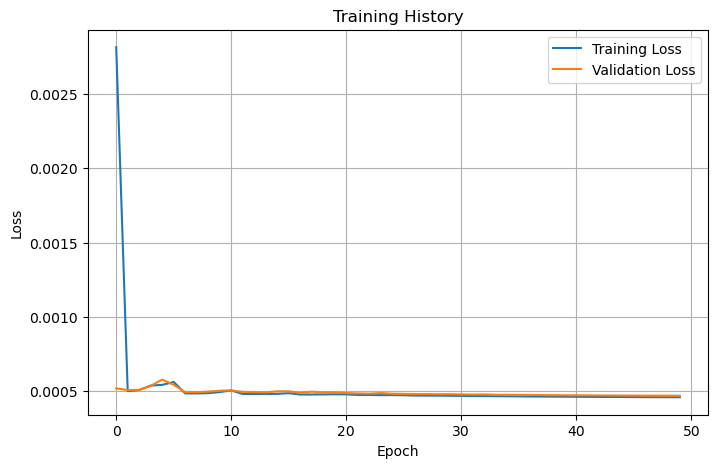

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

def compile_and_prepare_model(model, initial_learning_rate=1e-3):
    
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse',
        weighted_metrics=[]
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=1e-6,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

lr_scheduler_flux, early_stop_flux = compile_and_prepare_model(my_model_V_in_I_out_PEWC)

# 測試模型結構是否正確 (無condition torque 為假輸入)
my_model_V_in_I_out_PEWC.predict([ past_voltages[0:1,:,:], torque_array[0:1,:], torque_array[0:1,:]])  
#測試模型是否能夠正確讀取
my_model_V_in_I_out_PEWC.save(os.path.join(model_path, model_name + '_EMF.keras'))
my_model_V_in_I_out_PEWC= load_model(os.path.join(model_path, model_name + '_EMF.keras'))
print("Model structures passed, start training...")


with tf.device('/GPU:0'):
    print("開始訓練...")
    history_VI = my_model_V_in_I_out_PEWC.fit(
        x=[past_voltages_normalized, torque_array, torque_array], 
        y=past_currents_normalized,
        batch_size=128,
        epochs=50,
        validation_split=0.1, 
        callbacks=[lr_scheduler_flux, early_stop_flux] 
    )

plt.figure(figsize=(8, 5))
plt.plot(history_VI.history['loss'], label='Training Loss')
if 'val_loss' in history_VI.history:
    plt.plot(history_VI.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

# save model 
my_model_V_in_I_out_PEWC.save(os.path.join(model_path, model_name + '_VI.keras'))

metadata = {
    "model_name": model_name+'_VI',
    "sequence_length": sequence_length,
    "trained": True,
    "train_loss": history_VI.history['loss'][-1],
    "val_loss": history_VI.history.get('val_loss', [None])[-1],
    "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

with open(os.path.join(model_path, model_name + '_VI_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)


1/1 [==============================] - 0s 226ms/step
Model structures passed, start training...
(48000, 1024, 2)
開始訓練...
Epoch 1/20
338/338 [==============================] - 10s 23ms/step - loss: 0.0024 - val_loss: 3.2651e-04 - lr: 0.0010
Epoch 2/20
338/338 [==============================] - 7s 22ms/step - loss: 2.9032e-04 - val_loss: 2.6303e-04 - lr: 0.0010
Epoch 3/20
338/338 [==============================] - 7s 22ms/step - loss: 2.9810e-04 - val_loss: 2.4255e-04 - lr: 0.0010
Epoch 4/20
338/338 [==============================] - 7s 22ms/step - loss: 2.9963e-04 - val_loss: 2.4619e-04 - lr: 0.0010
Epoch 5/20
338/338 [==============================] - 8s 23ms/step - loss: 3.1043e-04 - val_loss: 2.7300e-04 - lr: 0.0010
Epoch 6/20
336/338 [============================>.] - ETA: 0s - loss: 3.0443e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
338/338 [==============================] - 8s 23ms/step - loss: 3.0404e-04 - val_loss: 2.3133e-04 - lr: 0.0010
Epoc

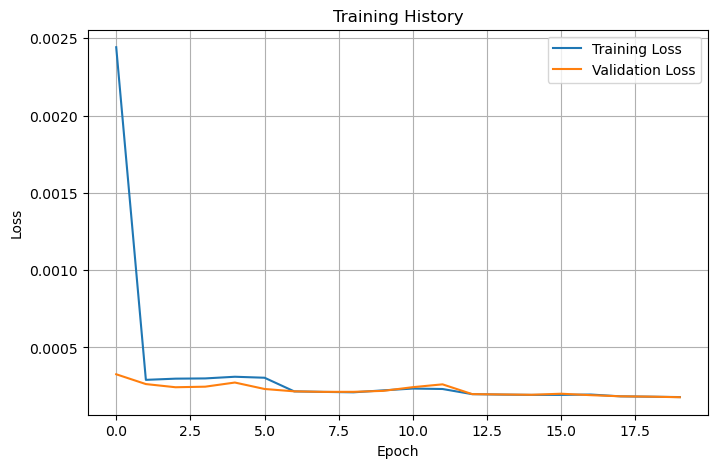

In [ ]:
def compile_and_prepare_model(model, initial_learning_rate=1e-3):
    
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse',
        weighted_metrics=[]
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=1e-6,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

lr_scheduler_flux, early_stop_flux = compile_and_prepare_model(my_model_I_in_I_out_PEWC)

# 測試模型結構是否正確 (無condition torque 為假輸入)
my_model_I_in_I_out_PEWC.predict([ past_currents_normalized[0:1,:,:], torque_array[0:1,:], torque_array[0:1,:]])  
#測試模型是否能夠正確讀取
my_model_I_in_I_out_PEWC.save(os.path.join(model_path, model_name + '_EMF.keras'))
my_model_I_in_I_out_PEWC= load_model(os.path.join(model_path, model_name + '_EMF.keras'))
print("Model structures passed, start training...")

print(past_currents_normalized.shape)
with tf.device('/GPU:0'):
    print("開始訓練...")
    history_VI = my_model_I_in_I_out_PEWC.fit(
        x=[past_currents_normalized, torque_array, torque_array], 
        y=past_currents_normalized,
        batch_size=128,
        epochs=20,
        validation_split=0.1, 
        callbacks=[lr_scheduler_flux, early_stop_flux] 
    )

# save model 
my_model_I_in_I_out_PEWC.save(os.path.join(model_path, model_name + '_II.keras'))

metadata = {
    "model_name": model_name+'_II',
    "sequence_length": sequence_length,
    "trained": True,
    "train_loss": history_VI.history['loss'][-1],
    "val_loss": history_VI.history.get('val_loss', [None])[-1],
    "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

with open(os.path.join(model_path, model_name + '_II_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

plt.figure(figsize=(8, 5))
plt.plot(history_VI.history['loss'], label='Training Loss')
if 'val_loss' in history_VI.history:
    plt.plot(history_VI.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()


套用模型

In [7]:


rul5_files = [f for f in os.listdir(rul5_dataset_path) if os.path.isfile(os.path.join(rul5_dataset_path, f))]
# 將 rul5_dataset_path 路徑加回 rul5_files，得到完整路徑列表
rul5_files = [os.path.join(rul5_dataset_path, f) for f in rul5_files]

train_files_rul5, val_files_rul5 = train_test_split(rul5_files[0:training_file_numbers], test_size=0.2)

rul5_test_files=get_augment_data_from_files(train_files_rul5,100)
past_voltages_rul5 = rul5_test_files["input_signals"][:, :, 0:2]
past_currents_rul5 = rul5_test_files["input_signals"][:, :, 2:4]
past_voltages_normalized_rul5 = rul5_test_files["input_signals_normalized"][:, :, 0:2]
past_currents_normalized_rul5 = rul5_test_files["input_signals_normalized"][:, :, 2:4]
torque_array_rul5 = rul5_test_files["torque_array"]
print(f"train_input_signals shape: {past_voltages_normalized_rul5.shape}")
print(f"torque_array shape: {torque_array_rul5.shape}")

train_input_signals shape: (24000, 1024, 2)
torque_array shape: (24000, 1)


## Comparison ##
in time

1/1 [==============================] - 0s 38ms/step


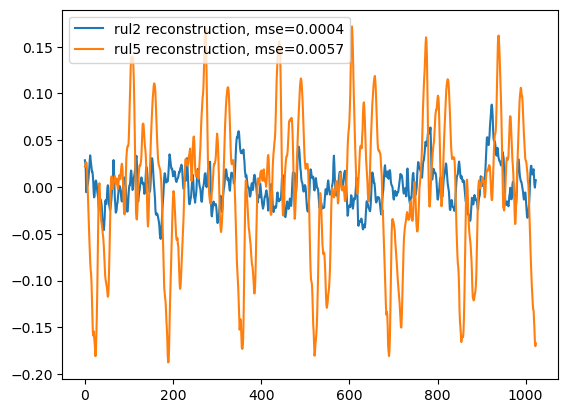

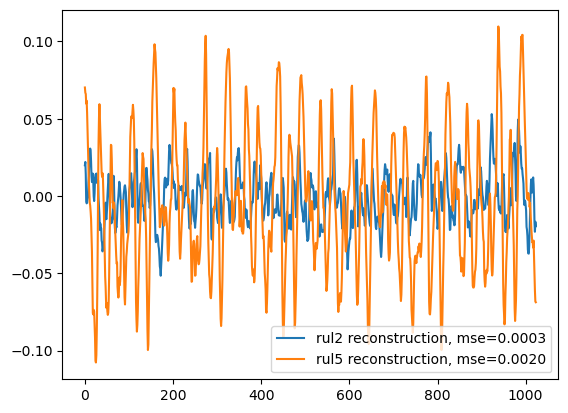

In [8]:
my_model_V_in_I_out_PEWC=load_model(os.path.join(model_path, model_name + '_VI.keras'))
my_model_I_in_I_out_PEWC=load_model(os.path.join(model_path, model_name + '_II.keras'))
verify_results_rul2_VI = my_model_V_in_I_out_PEWC.predict([ past_voltages_normalized[0:1,:,:], torque_array[0:1,:], torque_array[0:1,:]])  
verify_results_rul5_VI = my_model_V_in_I_out_PEWC.predict([ past_voltages_normalized_rul5[0:1,:,:], torque_array_rul5[0:1,:], torque_array_rul5[0:1,:]])  
verify_results_rul2_II = my_model_I_in_I_out_PEWC.predict([ past_currents_normalized[0:1,:,:], torque_array[0:1,:], torque_array[0:1,:]])  
verify_results_rul5_II = my_model_I_in_I_out_PEWC.predict([ past_currents_normalized_rul5[0:1,:,:], torque_array_rul5[0:1,:], torque_array_rul5[0:1,:]])  

# check the reconstruction VI vs II in rul2  
plt.figure()
errorsrul2=past_currents_normalized[0,:,0]-verify_results_rul2_VI[0, :, 0]
errorsrul5=past_currents_normalized_rul5[0,:,0]-verify_results_rul5_VI[0, :, 0]
plt.plot(errorsrul2, label=f'rul2 reconstruction, mse={np.mean(errorsrul2**2):.4f}')
plt.plot(errorsrul5, label=f'rul5 reconstruction, mse={np.mean(errorsrul5**2):.4f}')
plt.legend()

# check the reconstruction result 
plt.figure()
errorsrul2=past_currents_normalized[0,:,0]-verify_results_rul2_II[0, :, 0]
errorsrul5=past_currents_normalized_rul5[0,:,0]-verify_results_rul5_II[0, :, 0]
plt.plot(errorsrul2, label=f'rul2 reconstruction, mse={np.mean((errorsrul2**2)):.4f}')
plt.plot(errorsrul5, label=f'rul5 reconstruction, mse={np.mean((errorsrul5**2)):.4f}')
plt.legend()

In xy plot

In [9]:
# val_data_rul2 = get_augment_data_from_files(val_files, augmen_sample_number=100)

# val_data_rul5 = get_augment_data_from_files(val_files_rul5, augmen_sample_number=100)

testing_file_numbers=100
test_augment_sample_number=10
val_data_rul2 = get_augment_data_from_files(rul2_files[training_file_numbers:training_file_numbers+testing_file_numbers], augmen_sample_number=test_augment_sample_number)

val_data_rul5 = get_augment_data_from_files(rul5_files[training_file_numbers:training_file_numbers+testing_file_numbers], augmen_sample_number=test_augment_sample_number)



reconstruction_rul2_VI= my_model_V_in_I_out_PEWC.predict([val_data_rul2["input_signals_normalized"][:, :, 0:2],
                                                    val_data_rul2["torque_array"],
                                                    val_data_rul2["torque_array"]], batch_size=512)

reconstruction_rul5_VI= my_model_V_in_I_out_PEWC.predict([val_data_rul5["input_signals_normalized"][:, :, 0:2],
                                                    val_data_rul5["torque_array"],
                                                    val_data_rul5["torque_array"]], batch_size=512)

reconstruction_rul2_II= my_model_I_in_I_out_PEWC.predict([val_data_rul2["input_signals_normalized"][:, :, 2:4],
                                                    val_data_rul2["torque_array"],
                                                    val_data_rul2["torque_array"]], batch_size=512)

reconstruction_rul5_II= my_model_I_in_I_out_PEWC.predict([val_data_rul5["input_signals_normalized"][:, :, 2:4],
                                                    val_data_rul5["torque_array"],
                                                    val_data_rul5["torque_array"]], batch_size=512)

reconstruction_errors_rul2_VI= {
            "EMF_alpha_MSE": np.mean((val_data_rul2["input_signals_normalized"][:,:,2] - reconstruction_rul2_VI[:,:,0])**2, axis=1),
            "EMF_beta_MSE": np.mean((val_data_rul2["input_signals_normalized"][:,:,3] - reconstruction_rul2_VI[:,:,1])**2, axis=1)
        }
reconstruction_errors_rul5_VI= {
            "EMF_alpha_MSE": np.mean((val_data_rul5["input_signals_normalized"][:,:,2] - reconstruction_rul5_VI[:,:,0])**2, axis=1),
            "EMF_beta_MSE": np.mean((val_data_rul5["input_signals_normalized"][:,:,3] - reconstruction_rul5_VI[:,:,1])**2, axis=1)
        }
reconstruction_errors_rul2_II= {
            "EMF_alpha_MSE": np.mean((val_data_rul2["input_signals_normalized"][:,:,2] - reconstruction_rul2_II[:,:,0])**2, axis=1),
            "EMF_beta_MSE": np.mean((val_data_rul2["input_signals_normalized"][:,:,3] - reconstruction_rul2_II[:,:,1])**2, axis=1)
        }
reconstruction_errors_rul5_II= {
            "EMF_alpha_MSE": np.mean((val_data_rul5["input_signals_normalized"][:,:,2] - reconstruction_rul5_II[:,:,0])**2, axis=1),
            "EMF_beta_MSE": np.mean((val_data_rul5["input_signals_normalized"][:,:,3] - reconstruction_rul5_II[:,:,1])**2, axis=1)
        }



2/2 [==============================] - 0s 35ms/step


26.705765100803532
24.917381084183088


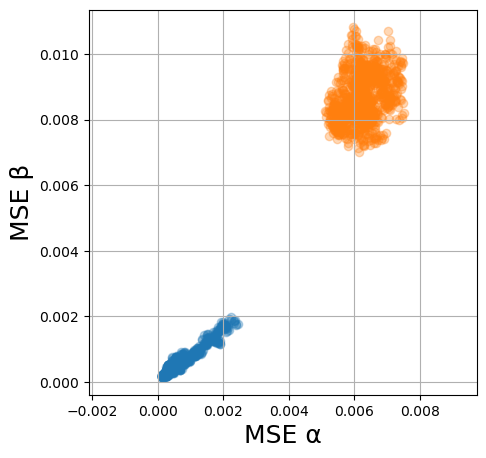

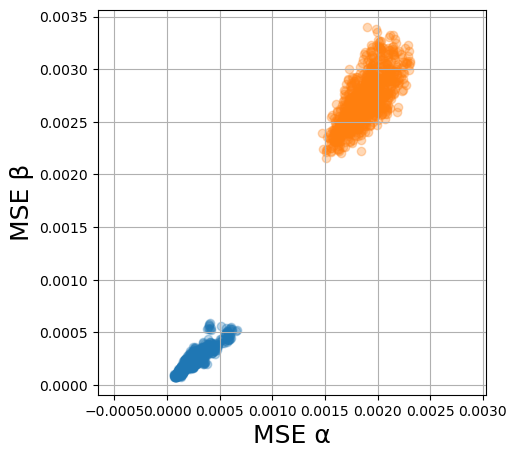

In [10]:
# 計算高斯分布參數
def Guassian_2D_MLE(x, y):
   data = np.stack((x, y), axis=1)
   mean_vector = np.mean(data, axis=0)
   cov_matrix = np.cov(data, rowvar=False)
   return mean_vector, cov_matrix

def Bhattacharyya_distnace_2D(mean_vector1, cov_matrix1, mean_vector2, cov_matrix2):
    # 計算 Bhattacharyya 距離
    
    cov_avg = (cov_matrix1 + cov_matrix2) / 2
    term1 = 0.5 * np.log(np.linalg.det(cov_avg) / np.sqrt(np.linalg.det(cov_matrix1) * np.linalg.det(cov_matrix2)))
    term2 = 0.125 * (mean_vector2 - mean_vector1).T @ np.linalg.inv(cov_avg) @ (mean_vector2 - mean_vector1)
    return term1 + term2

# BD results 
BD_II= {}
BD_VI = {}

# VI 模型
x_normal_VI = reconstruction_errors_rul2_VI["EMF_alpha_MSE"]
y_normal_VI = reconstruction_errors_rul2_VI["EMF_beta_MSE"]

outlier_number=2
# 去除離群值
sorted_idx = np.argsort(x_normal_VI)
selected_idx = sorted_idx[:len(x_normal_VI)-outlier_number*test_augment_sample_number]
x_normal_VI = x_normal_VI[selected_idx]
y_normal_VI = y_normal_VI[selected_idx]

x_abnormal2_VI = reconstruction_errors_rul5_VI["EMF_alpha_MSE"]
y_abnormal2_VI = reconstruction_errors_rul5_VI["EMF_beta_MSE"]
# 去除離群值
sorted_idx = np.argsort(x_abnormal2_VI)
selected_idx = sorted_idx[:len(x_abnormal2_VI)-outlier_number*test_augment_sample_number]
x_abnormal2_VI = x_abnormal2_VI[selected_idx]
y_abnormal2_VI = y_abnormal2_VI[selected_idx]

BD_VI=Bhattacharyya_distnace_2D(
            Guassian_2D_MLE(x_normal_VI, y_normal_VI)[0],
            Guassian_2D_MLE(x_normal_VI, y_normal_VI)[1],
            Guassian_2D_MLE(x_abnormal2_VI, y_abnormal2_VI)[0],
            Guassian_2D_MLE(x_abnormal2_VI, y_abnormal2_VI)[1]
        )

# II模型
x_normal_II = reconstruction_errors_rul2_II["EMF_alpha_MSE"]
y_normal_II = reconstruction_errors_rul2_II["EMF_beta_MSE"]
# 去除離群值
sorted_idx = np.argsort(x_normal_II)
selected_idx = sorted_idx[:len(x_normal_II)-outlier_number*test_augment_sample_number]
x_normal_II = x_normal_II[selected_idx]
y_normal_II = y_normal_II[selected_idx]

x_abnormal2_II = reconstruction_errors_rul5_II["EMF_alpha_MSE"]
y_abnormal2_II = reconstruction_errors_rul5_II["EMF_beta_MSE"]
# 去除離群值
sorted_idx = np.argsort(x_abnormal2_II)
selected_idx = sorted_idx[:len(x_abnormal2_II)-outlier_number*test_augment_sample_number]
x_abnormal2_II = x_abnormal2_II[selected_idx]
y_abnormal2_II = y_abnormal2_II[selected_idx]

BD_II= Bhattacharyya_distnace_2D(
            Guassian_2D_MLE(x_normal_II, y_normal_II)[0],
            Guassian_2D_MLE(x_normal_II, y_normal_II)[1],
            Guassian_2D_MLE(x_abnormal2_II, y_abnormal2_II)[0],
            Guassian_2D_MLE(x_abnormal2_II, y_abnormal2_II)[1]
)

# 先找到兩組數據的範圍
x_min = min(min(x_normal_VI), min(x_abnormal2_VI), min(x_normal_II), min(x_abnormal2_II))
x_max = max(max(x_normal_VI), max(x_abnormal2_VI), max(x_normal_II), max(x_abnormal2_II))
y_min = min(min(y_normal_VI), min(y_abnormal2_VI), min(y_normal_II), min(y_abnormal2_II))
y_max = max(max(y_normal_VI), max(y_abnormal2_VI), max(y_normal_II), max(y_abnormal2_II))

plt.figure(figsize=(5, 5))
plt.scatter(x_normal_VI, y_normal_VI, label="Normal", color='tab:blue', alpha=0.3)
plt.scatter(x_abnormal2_VI, y_abnormal2_VI, label="Validation", color='tab:orange', alpha=0.3)
plt.xlabel("MSE α", fontsize=18)
plt.ylabel("MSE β", fontsize=18)
plt.grid(True)
plt.axis("equal")   # XY 座標比例一致

plt.figure(figsize=(5, 5))
plt.scatter(x_normal_II, y_normal_II, label="Normal", color='tab:blue', alpha=0.3)
plt.scatter(x_abnormal2_II, y_abnormal2_II, label="Validation", color='tab:orange', alpha=0.3)
plt.xlabel("MSE α", fontsize=18)
plt.ylabel("MSE β", fontsize=18)
plt.grid(True)
plt.axis("equal")   # 各圖自己算範圍，但保持正方形比例

# plt.title(f"Reconstruction Errors II BD: {BD_II:.4f}", fontsize=18)
print(BD_VI)
print(BD_II)

In [11]:
for i in range((10)):
    print(rul5_files[i])

D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_2754.parquet
D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_2755.parquet
D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_2756.parquet
D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_2757.parquet
D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_2758.parquet
D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_2759.parquet
D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_2760.parquet
D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_2761.parquet
D:\Pycharm_conda_projects\PEWC data analysis\PEWC dataset\PEWC_raw_data_all\RUL_5\RUL_Data_5_2762.parquet
D:\Pycharm_conda_projects\PEWC data analysis\P

計算與健康樣本的馬式距離

In [ ]:
def get_augment_data_from_files_rul(files, augmen_sample_number=5):
    #進行資料增強
    train_signals=[] # vi signals alpha beta 
    train_signals_normalized=[]
    torque_array=[]
                
    for file_path in files:
        if os.path.exists(file_path):
            # read the data
            df = read_rul_data_PEWC(file_path)
            
            df["Voltage beta"] = df["Voltage alpha"] / 2 - df["Voltage beta"] * np.sqrt(3) / 2 
            torque, _, _, v_alpha, v_beta, power_sts = estimate_torque(df, debug=False)

            voltage_alpha= np.array(df["Voltage alpha"]).squeeze()
            voltage_beta= np.array(df["Voltage beta"]).squeeze()
            current_alpha= np.array(df["Current alpha"]).squeeze()
            current_beta= np.array(df["Current beta"]).squeeze()

            
            if len(torque) > 2500:
                if len(torque) == 4000:
                    torque_avg = np.mean(np.abs(torque[-2000:]))
                else :
                    torque_avg = np.mean(np.abs(torque[2250:2500]))
            else:
                torque_avg = np.mean(np.abs(torque[-500:]))
            
            # 合併測試資料至訓練維度 shape=(,4000,dim)
            temp_train_signals=[voltage_alpha, 
                                        voltage_beta,
                                        current_alpha,
                                        current_beta]
            
            temp_train_signals_normalized = []
            
            # 將數據標準化（均值為 0，標準差為 1）
            for signal in temp_train_signals:
                mean = np.mean(signal)
                std = np.std(signal)
                # 避免除以零的狀況（std == 0）
                if std == 0:
                    standardized = np.zeros_like(signal)
                else:
                    standardized = (signal - mean) / std
                temp_train_signals_normalized.append(standardized)
                    

            temp_train_signals = np.stack(temp_train_signals, axis=1)
            temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
            
            temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
            # 加入 train_input_signals
            train_signals.append(temp_train_input_signals_augmented)
            train_signals_normalized.append(temp_train_signals_normalized_augmented)
            torque_array.append(np.ones(augmen_sample_number) * torque_avg)
            
        else:
            print(f"File {file_path} does not exist.")
            
    train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
    train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
    torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)

    # 隨機打亂訓練資料
    indices = np.random.permutation(train_signals.shape[0])
    train_signals = train_signals[indices]
    train_input_signals = train_signals[:, :sequence_length, :]  # 取前 sequence_length 個
    # 正規化訓練資料
    train_signals_normalized = train_signals_normalized[indices]
    train_input_signals_normalized = train_signals_normalized[:, :sequence_length, :]
    torque_array = torque_array[indices]
    torque_array = torque_array.reshape(-1, 1)      # 將 torque_array 轉為 n, 1 batch 輸入狀態標籤

    # 訓練所需資料 (模型參考輸入)
    past_voltages=train_input_signals[:, :, 0:2]
    past_currents=train_input_signals[:, :, 2:4]
    # 正規畫資料
    past_voltages_normalized=train_input_signals_normalized[:, :, 0:2]
    past_currents_normalized=train_input_signals_normalized[:, :, 2:4] 
        # 將資料儲存到字典中
    # augment_data = {
    #     "input_signals": train_input_signals[:, :sequence_length, :],                         # 取前 sequence_length 個時間步長
    #     "input_signals_normalized": train_input_signals_normalized[:, :sequence_length, :],   # 取前 sequence_length 個時間步長
    #     "torque_array": torque_array
    # }
    return past_voltages_normalized, past_currents_normalized, torque_array

def mahalanobis_distance(xarray, yarray, mean, cov):
    """
    計算 (xarray, yarray) 每個點的馬氏距離

    參數
    ----
    xarray : array-like, shape (n,)
        x 座標
    yarray : array-like, shape (n,)
        y 座標
    mean : array-like, shape (2,)
        平均值向量 [mean_x, mean_y]
    cov : array-like, shape (2,2)
        共變異數矩陣

    回傳
    ----
    distances : ndarray, shape (n,)
        每個點的馬氏距離
    """
    xarray = np.asarray(xarray)
    yarray = np.asarray(yarray)
    mean = np.asarray(mean)
    cov = np.asarray(cov)

    # 計算 inverse covariance
    inv_cov = np.linalg.inv(cov)

    # 將 (x,y) 合併成樣本矩陣 shape=(n,2)
    points = np.column_stack((xarray, yarray))

    # 計算 Mahalanobis 距離 (向量化)
    diff = points - mean
    distances = np.sqrt(np.sum(diff @ inv_cov * diff, axis=1))
    return distances

health_mu, health_sigma = Guassian_2D_MLE(x_normal_VI, y_normal_VI)

start_file_idx=training_file_numbers+testing_file_numbers
end_file_idx=start_file_idx+10
rul2_Vdata_time, rul2_Idata_time, rul2_Torque_time = get_augment_data_from_files_rul(rul2_files[start_file_idx:end_file_idx], augmen_sample_number=5)
rul5_Vdata_time, rul5_Idata_time, rul5_Torque_time = get_augment_data_from_files_rul(rul5_files[start_file_idx:end_file_idx], augmen_sample_number=5)

reconstruction_rul2_VI= my_model_V_in_I_out_PEWC.predict([rul2_Vdata_time,
                                                    rul2_Torque_time,
                                                    rul2_Torque_time], batch_size=512)
reconstruction_rul5_VI= my_model_V_in_I_out_PEWC.predict([rul5_Vdata_time,
                                                    rul5_Torque_time,
                                                    rul5_Torque_time], batch_size=512)


rul2_mse_time = np.mean((rul2_Idata_time-reconstruction_rul2_VI)**2, axis=1)         # shape = (50, 2)
rul5_mse_time = np.mean((rul5_Idata_time-reconstruction_rul5_VI)**2, axis=1)         # shape = (50, 2)

# reconstruction_errors_rul2_VI= {
#             "EMF_alpha_MSE": np.mean((val_data_rul2["input_signals_normalized"][:,:,2] - reconstruction_rul2_VI[:,:,0])**2, axis=1),
#             "EMF_beta_MSE": np.mean((val_data_rul2["input_signals_normalized"][:,:,3] - reconstruction_rul2_VI[:,:,1])**2, axis=1)
#         }



1/1 [==============================] - 0s 70ms/step


In [19]:
mse.shape

(50, 2)

雙軸電流誤差計算

In [14]:
# 計算重建殘差
# 以 one_test_batch_files 個檔案維一個資料集分析變化

# 儲存重建誤差值
reconstruction_errs_batches_ab = [] # 以batch 儲存重建誤差原始值(每一元素為該批次資料之原始重建誤差)
reconstruction_mse_batches_ab=[]# 儲存重建誤差mse(每一點為該批次資料之mse)
for start_idx in range(0, test_input_augmented.shape[0], data_per_test_bartch):
    end_idx=start_idx + data_per_test_bartch
    reconstruc_err_per_batch_alpha=test_input_augmented[start_idx:end_idx,:,0:1] - (test_results[0][start_idx:end_idx,:])
    reconstruc_err_per_batch_beta=test_input_augmented[start_idx:end_idx,:,1:2] - (test_results[1][start_idx:end_idx,:])
    reconstruc_err_per_batch = np.concatenate((reconstruc_err_per_batch_alpha, reconstruc_err_per_batch_beta), axis=1)
    reconstruction_errs_batches_ab.append(reconstruc_err_per_batch)
    
    # 將批次誤差一維化並聚攏，方便計算最終mse值
    flattened_batch_err= np.array(reconstruc_err_per_batch).flatten()
    reconstruction_mse_batches_ab.append(np.mean(np.square(flattened_batch_err)))

NameError: name 'test_input_augmented' is not defined

Text(0, 0.5, 'Error')

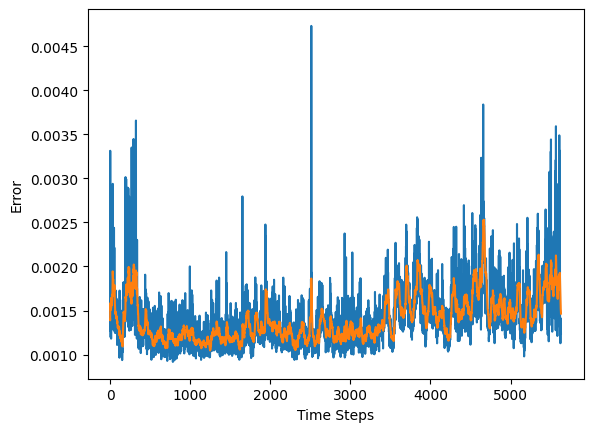

In [ ]:

# 對 reconstruction_mse_batches_ab 做指數平滑
def exponential_smoothing(data, alpha=0.1):
    smoothed = [data[0]]
    for v in data[1:]:
        smoothed.append(alpha * v + (1 - alpha) * smoothed[-1])
    return smoothed

reconstruction_mse_batches_ab_smooth = exponential_smoothing(reconstruction_mse_batches_ab, alpha=0.1)
# # 繪製重建殘差
plt.figure()

plt.plot( reconstruction_mse_batches_ab, label='Reconstruction Error')
plt.plot( reconstruction_mse_batches_ab_smooth, label='Reconstruction Error')
plt.xlabel('Time Steps')
plt.ylabel('Error')

Save the prediction result

In [ ]:
import pickle
from datetime import datetime

epochs=10
batch_size=100

model_type = 'I2_in_I2_out'

prediction_results = {
    "Model_type": model_type,
    "Model_name": model_save_name,
    "Input_type": "alpha_beta",
    "Output_type": "alpha_beta",
    "Training_info": {
        "epochs": epochs,
        "batch_size": batch_size,
        "optimizer": "adam",
        "loss": "mse",
    },
    "Evaluation": {
        "reconstruction_errs_batches_alpha": reconstruction_errs_batches_ab,
        "reconstruction_mse_batches": reconstruction_mse_batches_ab,
    },
    "Timestamps": {
        "saved_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
}

result_save_path=os.path.join(model_saved_path, f"{model_type}_results.pkl")
with open(result_save_path, "wb") as f:
    pickle.dump(prediction_results, f)


NameError: name 'model_save_name' is not defined